In [ ]:
# TBD: create bash script
# To download kssl dataset
# pip install gdown install --upgrade --no-cache-dir gdown

# cd /root
# python
# import gdown
# Links: 
#   - NIRS LUCAS: "1OnwGgDqvjnDYEik14h_lSi83M4AwzYBt"
# id = "1qh8isMQIzhArsj3RNWJe6g0lx_cs7iBG" # MIRS KSSL v1 or "1SzQZqpbJuK3iCqjJYabuEobbgPXm3cHT" for v2
# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

# paperspace only
#!pip install gdown 
#!pip install --upgrade gdown

In [ ]:
!pip install spanda

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 2.3 MB/s eta 0:00:0000:0100:01
  Created wheel for brukeropusreader: filename=brukeropusreader-1.3.4-py3-none-any.whl size=5310 sha256=989039299ad1aafc85fbc92c90b6374827a41863fe7a7d23b6489042da83b406
  Stored in directory: /home/.cache/pip/wheels/77/7b/d8/049934711ed9028dd2c5fe6c9d597ed3331b10f59f96bc6587
Successfully built brukeropusreader


In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from pathlib import Path

from fastai.vision.all import *
from fastai.data.all import *
from tqdm import tqdm
import timm
from sklearn.metrics import r2_score

from spanda.data.transforms import (SpectraBlock, AnalytesBlock, Analytes, SpectraTfm, 
                                    TrimTfm, AnalytesTfm, SNVTfm, RandWAvgTfm, AvgTfm, GADFTfm, 
                                    To3DTfm, ResizeTfm, LogTfm)

use_cuda = torch.cuda.is_available()
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'


import warnings
warnings.filterwarnings('ignore')

analyte_name = 'K'

## Training KSSL

In [ ]:
# Only samples with spectra
path = Path('lucas-nirs')
paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]; print(f'n samples: {len(paths)}')

100%|██████████████████████████████████| 21782/21782 [00:00<00:00, 45091.99it/s]

n samples: 21782


In [ ]:
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

In [ ]:
# Only strictly positive measurements
paths = [p for p in tqdm(paths) if AnalytesTfm(analytes=[analyte_name])(get_target(p)) != 0] 
print(f'n samples: {len(paths)}')

100%|████████████████████████████████████| 21782/21782 [00:36<00:00, 596.21it/s]

n samples: 21779


In [ ]:
class Lucas2KSSLTfm(Transform):        
    def encodes(self, 
                y:Analytes
               ):
        m_k = 39.0983
        return y/(m_k*10)

## GADF

In [ ]:
n_smp = None # None for all

get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=[analyte_name])),
                   get_x=get_spectra,
                   get_y=get_target,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=[AvgTfm, GADFTfm, ResizeTfm,
                              LogTfm])

dls = dblock.dataloaders(paths[:n_smp], bs=32, num_workers=6)
#dls.show_batch()

In [ ]:
dls.one_batch()[0][0].shape

torch.Size([1, 256, 256])

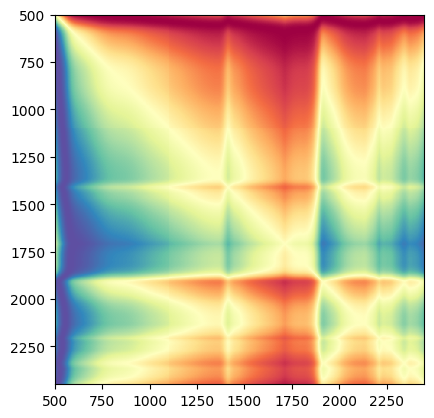

In [ ]:
plt.imshow(dls.one_batch()[0][1].squeeze().cpu(), cmap='Spectral', 
           origin='upper', extent=[500,2450,2450,500]);

In [ ]:
learn = vision_learner(dls, 'resnet18', loss_func=MSELossFlat(), metrics=R2Score(), n_out=1, n_in=1).to_fp16()

In [ ]:
#learn.summary()

SuggestedLRs(valley=0.002511886414140463)

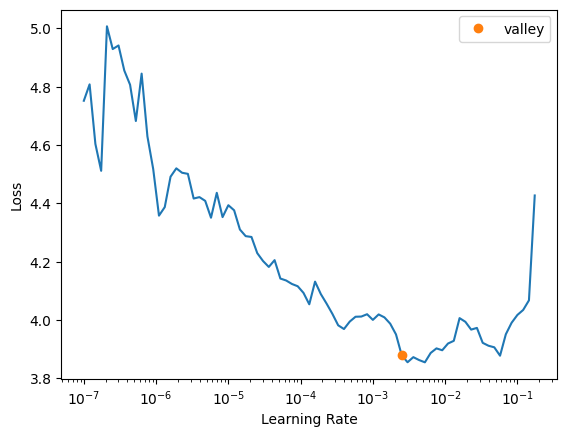

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10, 2e-3)

epoch,train_loss,valid_loss,r2_score,time
0,0.241418,0.124823,0.150497,08:30


epoch,train_loss,valid_loss,r2_score,time
0,0.127831,0.092460,0.370752,08:30
1,0.116380,0.102781,0.300509,08:30
2,0.110912,0.093568,0.363209,09:06
3,0.113879,0.089552,0.390541,09:09
4,0.101460,0.081349,0.446367,09:07
5,0.091123,0.082444,0.438914,09:01
6,0.087222,0.076135,0.481851,08:51
7,0.078413,0.074090,0.495769,08:51
8,0.079296,0.072586,0.506002,08:47
9,0.074440,0.074924,0.490092,08:49


In [ ]:
#learn.save('xresnet18-kex-mirs-kssl-20-epochs-lr-1e3-r2-0.813-260323')

Path('models/xresnet18-kex-mirs-kssl-20-epochs-lr-1e3-r2-0.813-260323.pth')

## 1D

In [ ]:
n_smp = None # None for all

#get_spectra = lambda o: L(fname for fname in o.ls() if re.match('\d+_\d', fname.name))
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=['K'])),
                   get_x=get_spectra,
                   get_y=get_target,
                   splitter=RandomSplitter(),
                   item_tfms=[AvgTfm(), SNVTfm(),
                              LogTfm])

dls = dblock.dataloaders(paths[:n_smp], bs=32, num_workers=6)
dls.show_batch(max_n=3)

NameError: name 'DataBlock' is not defined

In [ ]:
dls.one_batch()[0].shape

torch.Size([32, 1, 3901])

In [ ]:
# Create Learner
model_1D = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
learn_1D = Learner(dls, model_1D, loss_func=MSELossFlat(), metrics=R2Score())

SuggestedLRs(valley=2.2908675418875646e-06)

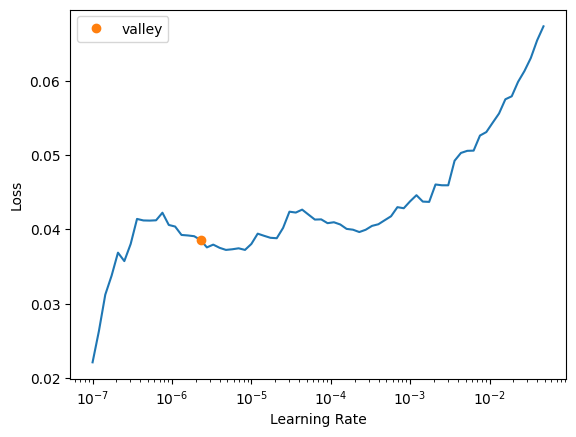

In [ ]:
learn_1D.lr_find()

In [ ]:
learn_1D.fit_one_cycle(10, 2e-6)

epoch,train_loss,valid_loss,r2_score,time
0,0.040081,0.060134,0.604971,00:33
1,0.040649,0.060706,0.601218,00:32
2,0.040139,0.060024,0.605698,00:32
3,0.041378,0.060393,0.603269,00:32
4,0.043538,0.060188,0.604616,00:32
5,0.038604,0.060225,0.604374,00:33
6,0.039742,0.060510,0.602503,00:33
7,0.041437,0.060210,0.604476,00:33


In [ ]:
learn_1D.save('xresnet18-kex-nirs-lucas-40-epochs-lr-1e3-r2-0.6-060623')